## Import

In [16]:
import random
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore') 

## Fixed Random-Seed

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## Load Data

In [9]:
import zipfile
from zipfile import ZipFile
from io import BytesIO

filepath_zip = '../data/open.zip'
with ZipFile(filepath_zip,'r') as zipObj:
    list_filenames = zipObj.namelist()
    for filename in list_filenames:
        if filename.endswith('.csv'):
            zipRead = zipObj.read(filename)
            globals()[f'{filename[5:-4]}'] = pd.read_csv(BytesIO(zipRead))
            print('df객체명 :',filename[5:-4])

df객체명 : international_trade
df객체명 : sample_submission
df객체명 : test
df객체명 : train


### EDA

In [14]:
train.head()

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


In [15]:
international_trade.head()

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38


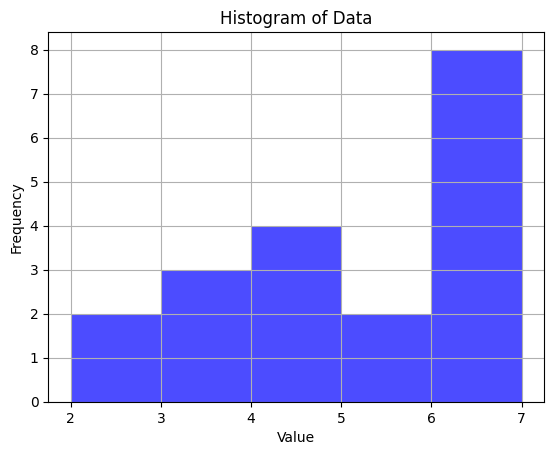

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 예제 데이터 생성
data = [2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7]

# 데이터를 Pandas Series로 변환
series = pd.Series(data)

# 히스토그램 그리기
plt.hist(series, bins=5, color='blue', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.grid(True)
plt.show()


## Data Pre-Processing

In [4]:
#시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다
train_df['year'] = train_df['timestamp'].apply(lambda x : int(x[0:4]))
train_df['month'] = train_df['timestamp'].apply(lambda x : int(x[5:7]))
train_df['day'] = train_df['timestamp'].apply(lambda x : int(x[8:10]))

test_df['year'] = test_df['timestamp'].apply(lambda x : int(x[0:4]))
test_df['month'] = test_df['timestamp'].apply(lambda x : int(x[5:7]))
test_df['day'] = test_df['timestamp'].apply(lambda x : int(x[8:10]))

In [5]:
#학습에 사용하지 않을 변수들을 제거합니다
train_x = train_df.drop(columns=['ID', 'timestamp', 'supply(kg)', 'price(원/kg)'])
train_y = train_df['price(원/kg)']

test_x = test_df.drop(columns=['ID', 'timestamp'])

In [6]:
#질적 변수들을 수치화합니다
qual_col = ['item', 'corporation', 'location']

for i in qual_col:
    le = LabelEncoder()
    train_x[i]=le.fit_transform(train_x[i])
    test_x[i]=le.transform(test_x[i]) #test 데이터에 대해서 fit하는 것은 data leakage에 해당합니다

print('Done.')

Done.


## Regression Model Fit

In [7]:
model = RandomForestRegressor()
model.fit(train_x, train_y)

RandomForestRegressor()

## Inference

In [8]:
preds = model.predict(test_x)

## Submission

In [9]:
submission = pd.read_csv('./sample_submission.csv')
submission

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
...,...,...
1087,RD_F_J_20230327,0
1088,RD_F_J_20230328,0
1089,RD_F_J_20230329,0
1090,RD_F_J_20230330,0


In [10]:
submission['answer'] = preds
submission

,ID,answer
0,TG_A_J_20230304,3636.64
1,TG_A_J_20230305,4109.28
2,TG_A_J_20230306,401.82
3,TG_A_J_20230307,3277.93
4,TG_A_J_20230308,3067.03
...,...,...
1087,RD_F_J_20230327,271.27
1088,RD_F_J_20230328,441.28
1089,RD_F_J_20230329,439.31
1090,RD_F_J_20230330,436.00


In [11]:
submission.to_csv('./baseline_submission.csv', index=False)